In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from typing import List, Optional, Tuple
import sys
import os

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))
from data_loader import DataLoader

%matplotlib inline
plt.style.use('default')
sns.set_palette("husl")

plt.rcParams['figure.figsize'] = (15, 10)

In [82]:
data_file_path = "../data/raw/sqig_credit_spread_volatility.csv"

try:
    # Create DataLoader instance and load data
    loader = DataLoader(data_file_path)
    df = loader.load_data(parse_dates=True)
    
    print("\nData loaded successfully!")
    
except Exception as e:
    print(f"Error: {e}")

Data loaded from ../data/raw/sqig_credit_spread_volatility.csv
Shape: (1827, 4)
Date range: 2018-01-01 00:00:00 to 2024-12-31 00:00:00

Data loaded successfully!


In [83]:
def plot_time_series(df: pd.DataFrame, 
                    columns: Optional[List[str]] = None,
                    title: str = "Time Series Analysis",
                    save_path: Optional[str] = None,
                    figure_size: Tuple[int, int] = (15, 10)):
    """
    Plot time series for specified columns
    Creates subplots for each numeric column showing trends over time
    """
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns.tolist()

    n_cols = len(columns)
    n_rows = (n_cols + 1) // 2

    fig, axes = plt.subplots(n_rows, 2, figsize = figure_size)
    fig.suptitle(title, fontsize=16)

    # Handle single subplot case
    if n_cols == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i, col in enumerate(columns):
        if i < len(axes):
            axes[i].plot(df.index, df[col], linewidth=1.5)
            axes[i].set_title(f'{col} Over Time')
            axes[i].set_xlabel('Date')
            axes[i].set_ylabel(col)
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].grid(True, alpha=0.3)

    # Hide unused subplots
    for i in range(len(columns), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Time series plot saved to {save_path}")
    
    plt.show()

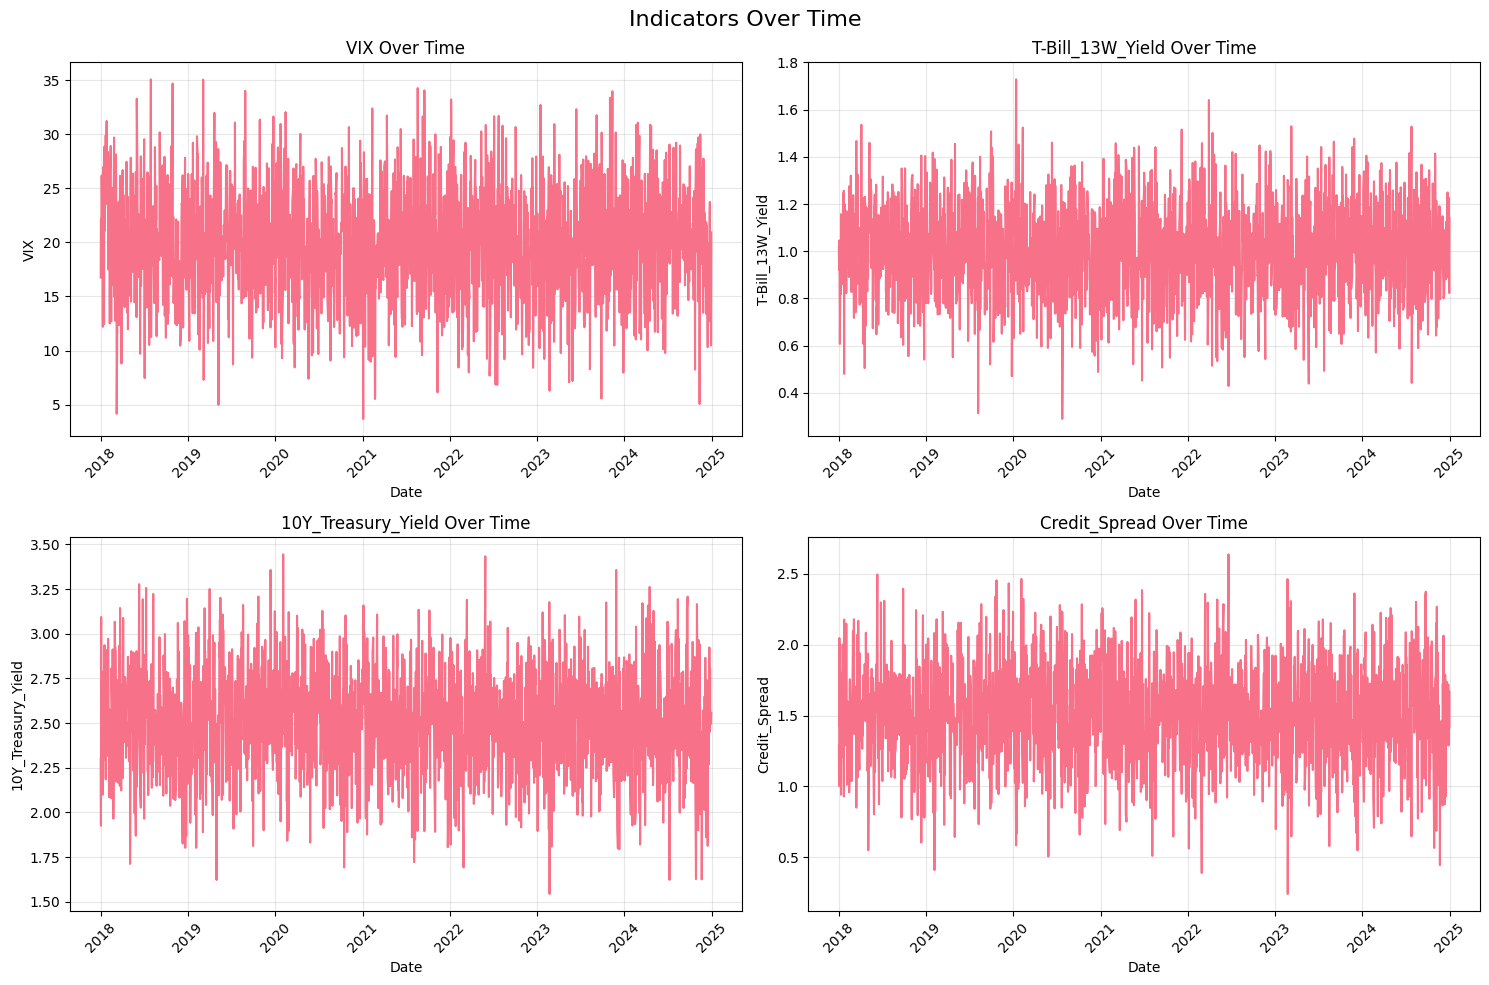

In [84]:
# Generate time series plots
plot_time_series(df, title = "Indicators Over Time")

In [85]:
def plot_correlation_matrix(df: pd.DataFrame,
                           columns: Optional[List[str]] = None,
                           title: str = "Correlation Matrix",
                           save_path: Optional[str] = None):
    """
    Plot correlation heatmap showing relationships between variables
    Uses masked upper triangle to avoid redundancy
    """
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    correlation_matrix = df[columns].corr()
    
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    sns.heatmap(correlation_matrix, 
               mask=mask,
               annot=True, 
               cmap='coolwarm', 
               center=0,
               square=True, 
               fmt='.2f',
               cbar_kws={"shrink": .8})
    
    plt.title(title, fontsize=16)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Correlation matrix saved to {save_path}")
    
    plt.show()
    
    return correlation_matrix

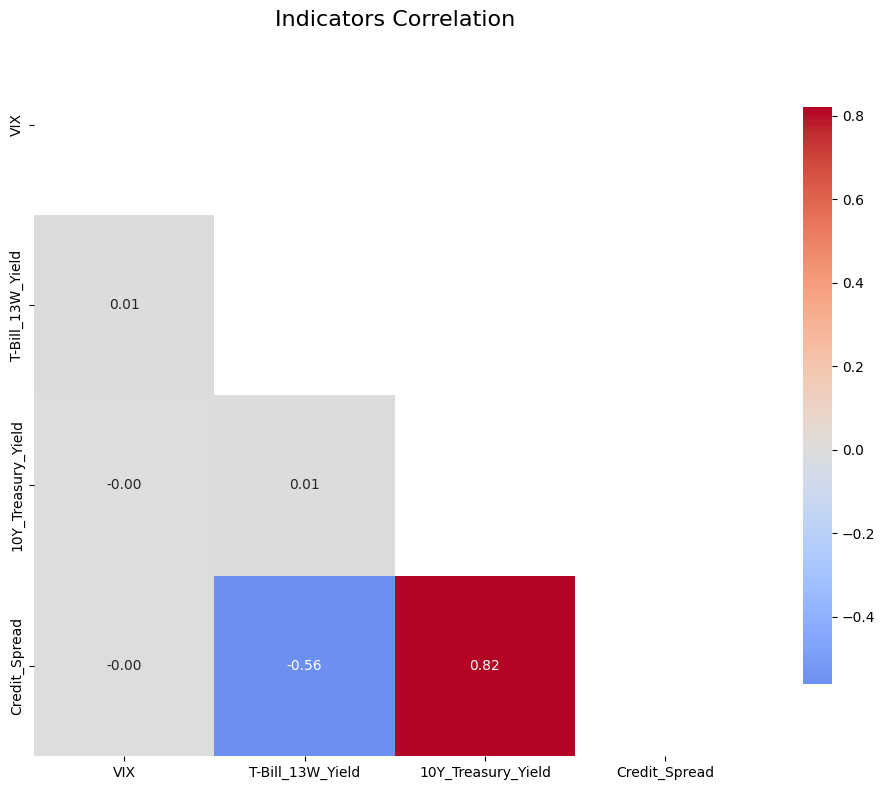


Correlation Analysis Summary:
Strongest correlations:
  10Y_Treasury_Yield ↔ Credit_Spread: 0.822 (strong positive)
  T-Bill_13W_Yield ↔ Credit_Spread: -0.561 (moderate negative)
  T-Bill_13W_Yield ↔ 10Y_Treasury_Yield: 0.010 (weak positive)
  VIX ↔ T-Bill_13W_Yield: 0.006 (weak positive)
  VIX ↔ Credit_Spread: -0.004 (weak negative)


In [86]:
# Generate correlation matrix
correlation_matrix = plot_correlation_matrix(df, title="Indicators Correlation")

# Find and display strongest correlations
corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        col1 = correlation_matrix.columns[i]
        col2 = correlation_matrix.columns[j]
        corr_val = correlation_matrix.iloc[i, j]
        corr_pairs.append((col1, col2, corr_val))

# Sort by absolute correlation strength
corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

print("\nCorrelation Analysis Summary:")
print("Strongest correlations:")
for col1, col2, corr in corr_pairs[:5]:  # Show top 5
    direction = "positive" if corr > 0 else "negative"
    strength = "strong" if abs(corr) > 0.7 else "moderate" if abs(corr) > 0.4 else "weak"
    print(f"  {col1} ↔ {col2}: {corr:.3f} ({strength} {direction})")

In [87]:
def plot_distributions(df: pd.DataFrame,
                      columns: Optional[List[str]] = None,
                      title: str = "Distribution Analysis",
                      save_path: Optional[str] = None,
                      figure_size: Tuple[int, int] = (15, 10)):
    """
    Plot distribution histograms for specified columns
    Shows frequency distribution and mean line for each variable
    """
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    n_cols = len(columns)
    n_rows = (n_cols + 1) // 2
    
    fig, axes = plt.subplots(n_rows, 2, figsize=figure_size)
    fig.suptitle(title, fontsize=16)
    
    # Handle single subplot case
    if n_cols == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for i, col in enumerate(columns):
        if i < len(axes):
            axes[i].hist(df[col], bins=30, alpha=0.7, edgecolor='black', color='skyblue')
            axes[i].set_title(f'Distribution of {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')
            axes[i].grid(True, alpha=0.3)
            
            # Add statistics
            mean_val = df[col].mean()
            axes[i].axvline(mean_val, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_val:.2f}')
            axes[i].legend()
    
    # Hide unused subplots
    for i in range(len(columns), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Distribution plot saved to {save_path}")
    
    plt.show()

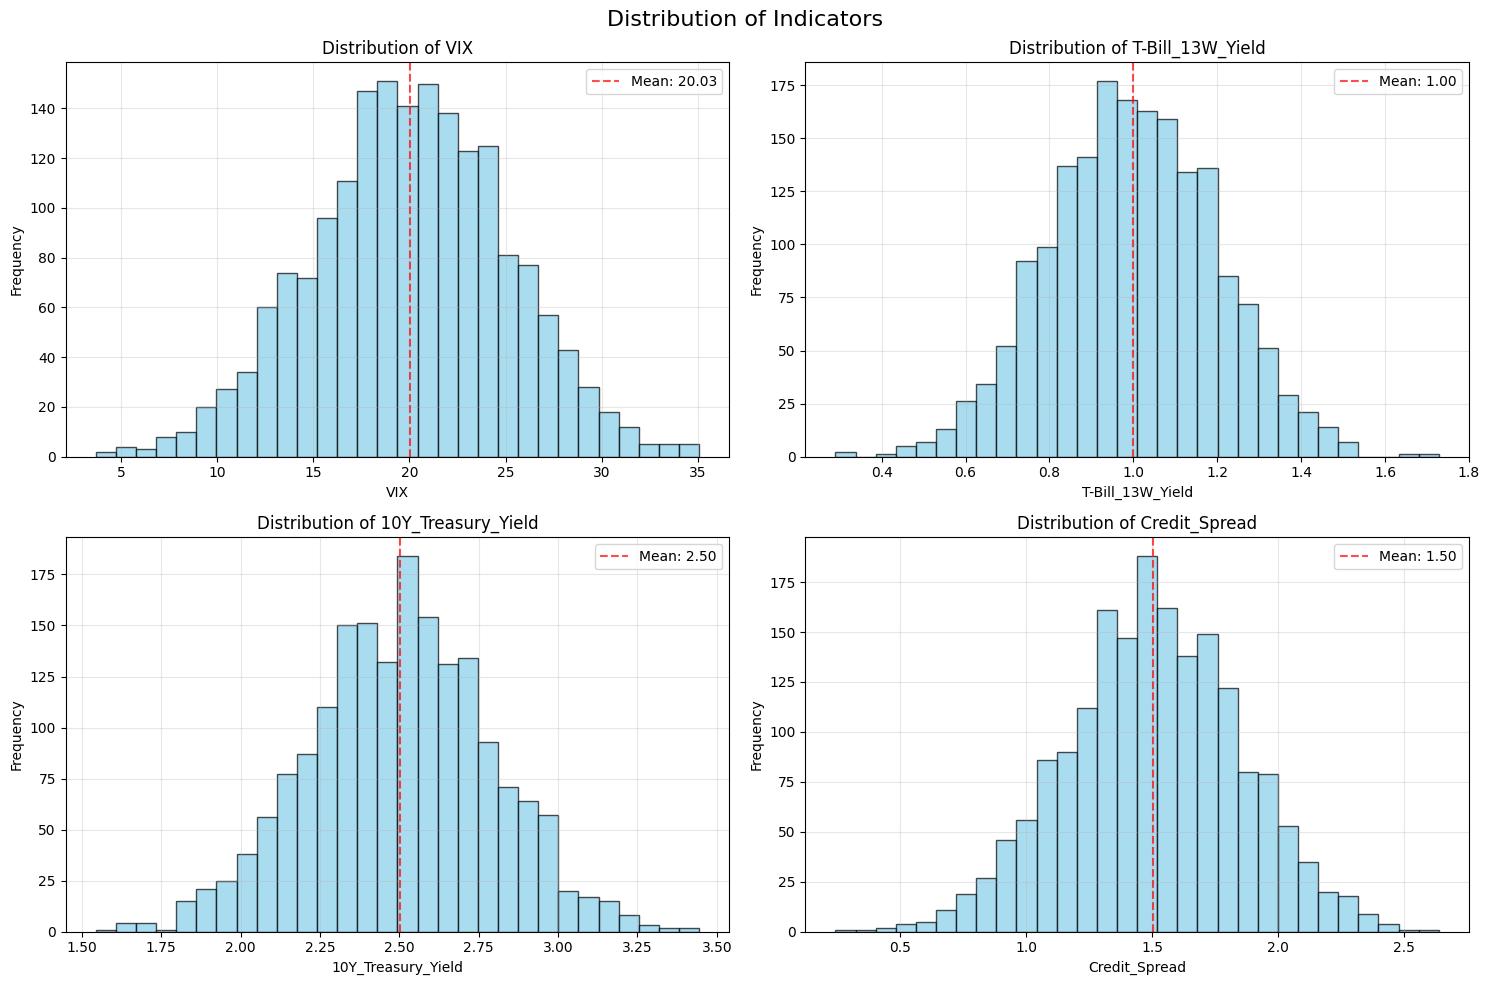


Distribution Summary:
  VIX: symmetric (skew: -0.07, kurtosis: -0.08)
  T-Bill_13W_Yield: symmetric (skew: -0.00, kurtosis: -0.07)
  10Y_Treasury_Yield: symmetric (skew: -0.03, kurtosis: -0.02)
  Credit_Spread: symmetric (skew: -0.06, kurtosis: -0.00)


In [88]:
# Generate distribution plots
plot_distributions(df, title="Distribution of Indicators")

# Print distribution statistics
print("\nDistribution Summary:")
for col in df.select_dtypes(include=[np.number]).columns:
    skewness = df[col].skew()
    kurtosis = df[col].kurtosis()
    skew_desc = "right-skewed" if skewness > 0.5 else "left-skewed" if skewness < -0.5 else "symmetric"
    print(f"  {col}: {skew_desc} (skew: {skewness:.2f}, kurtosis: {kurtosis:.2f})")

In [89]:
# FIXED Box Plot Function - No more random Q2 or blank space
def plot_box_plots(df: pd.DataFrame,
                        columns: Optional[List[str]] = None,
                        title: str = "Outlier Detection - Box Plots",
                        save_path: Optional[str] = None,
                        figure_size: Tuple[int, int] = (15, 10)):
    """
    Plot box plots for outlier detection - FIXED LAYOUT
    Shows quartiles, median, and outliers for each variable
    """
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    n_cols = len(columns)
    n_rows = (n_cols + 1) // 2
    
    # Create figure with proper spacing
    fig, axes = plt.subplots(n_rows, 2, figsize=figure_size)
    fig.suptitle(title, fontsize=16, y=0.98)  # Position title properly
    
    # Handle different subplot scenarios
    if n_cols == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for i, col in enumerate(columns):
        if i < len(axes):
            # Create box plot
            box_plot = axes[i].boxplot(df[col], patch_artist=True, 
                                     boxprops=dict(facecolor='lightblue', alpha=0.7),
                                     medianprops=dict(color='red', linewidth=2))
            
            axes[i].set_title(f'Box Plot: {col}', fontsize=12)
            axes[i].set_ylabel(col, fontsize=10)
            axes[i].grid(True, alpha=0.3)
            
            # Add quartile information PROPERLY positioned
            q1, q2, q3 = df[col].quantile([0.25, 0.5, 0.75])
            
            # Position text within the plot area (not outside)
            y_range = axes[i].get_ylim()
            y_pos = y_range[0] + (y_range[1] - y_range[0]) * 0.95  # 95% up from bottom
            
            axes[i].text(1.05, y_pos, f'Q2: {q2:.2f}', 
                        transform=axes[i].transData, 
                        fontsize=9, 
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    # Hide unused subplots
    for i in range(len(columns), len(axes)):
        axes[i].set_visible(False)
    
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)  # Leave space for main title
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Box plots saved to {save_path}")
    
    plt.show()

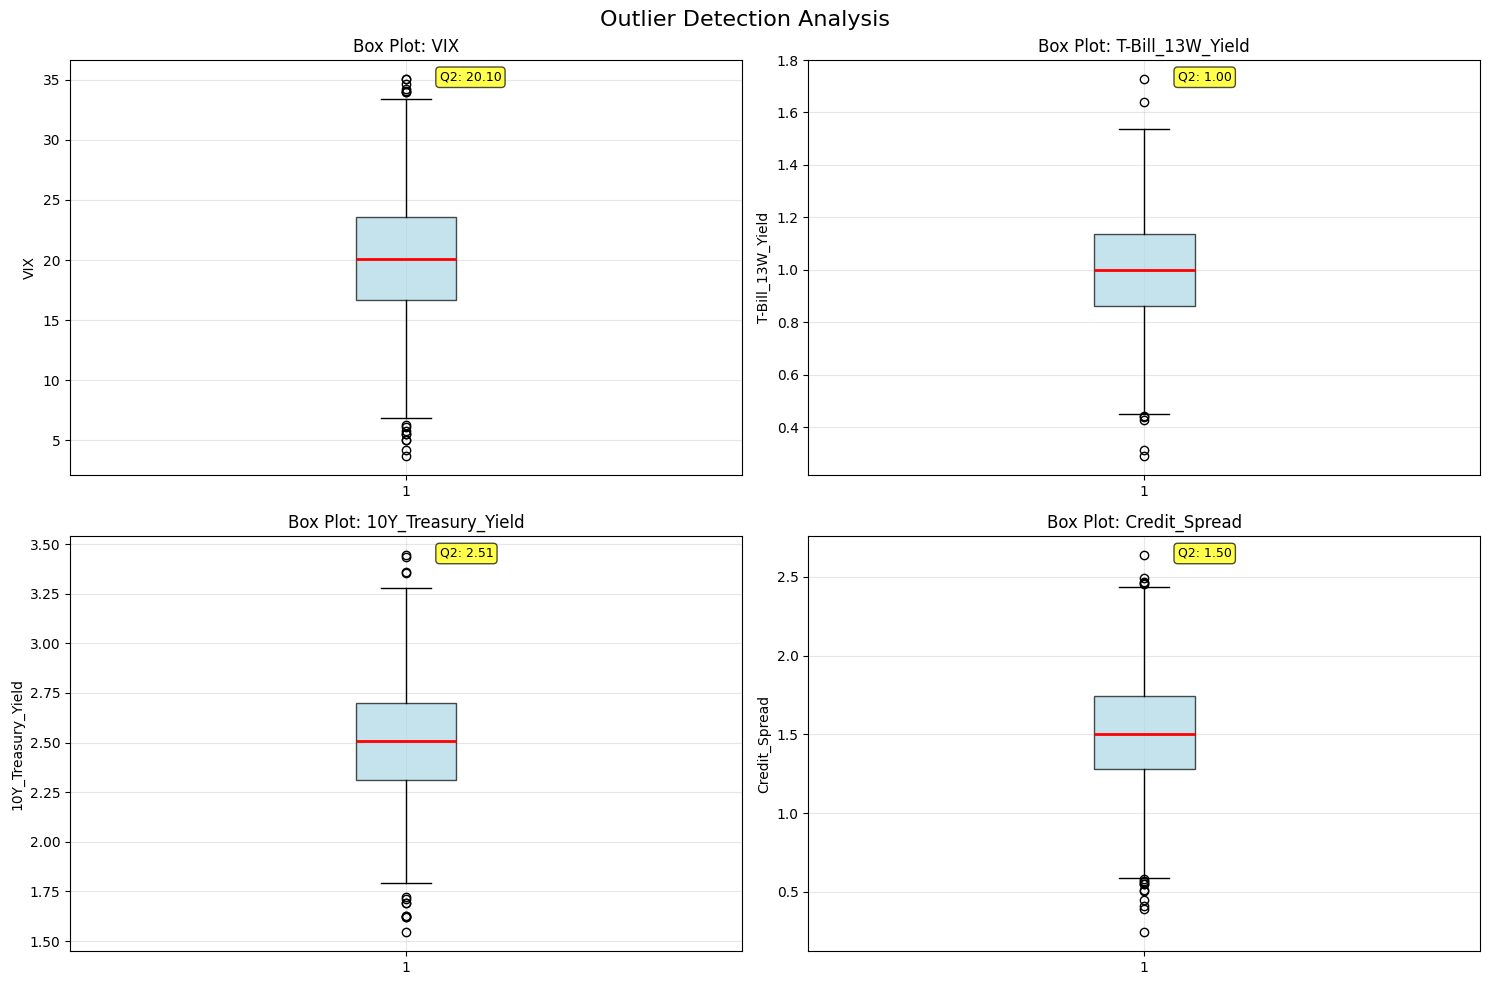


Outlier Summary:
  VIX: 16 outliers (0.9%)
  T-Bill_13W_Yield: 7 outliers (0.4%)
  10Y_Treasury_Yield: 13 outliers (0.7%)
  Credit_Spread: 16 outliers (0.9%)

Most outliers in: VIX (0.9%)


In [90]:
# Generate box plots
plot_box_plots(df, title="Outlier Detection Analysis")

# Calculate outlier statistics
print("\nOutlier Summary:")
outlier_summary = {}

for col in df.select_dtypes(include=[np.number]).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_pct = len(outliers) / len(df) * 100
    
    outlier_summary[col] = {
        'count': len(outliers),
        'percentage': outlier_pct,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }
    
    print(f"  {col}: {len(outliers)} outliers ({outlier_pct:.1f}%)")

# Identify columns with most outliers
most_outliers = max(outlier_summary.items(), key=lambda x: x[1]['percentage'])
print(f"\nMost outliers in: {most_outliers[0]} ({most_outliers[1]['percentage']:.1f}%)")

In [91]:
def plot_all_rolling_statistics(df: pd.DataFrame,
                               columns: Optional[List[str]] = None,
                               window: int = 30,
                               title: str = "Rolling Statistics - All Variables",
                               save_path: Optional[str] = None,
                               figure_size: Tuple[int, int] = (20, 15)):
    """
    Plot rolling statistics for ALL variables side by side
    Shows comprehensive trend and volatility analysis
    
    Args:
        df: DataFrame containing the data
        columns: List of columns to analyze (default: all numeric)
        window: Rolling window size (default 30 days)
        title: Main title for the entire plot
        save_path: Optional path to save the plot
        figure_size: Figure size tuple
    """
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    n_cols = len(columns)
    n_plot_cols = 2  # 2 columns of subplots
    n_plot_rows = (n_cols + 1) // 2  # Calculate rows needed
    
    # Create large figure to accommodate all variables
    fig, axes = plt.subplots(n_plot_rows, n_plot_cols, figsize=figure_size)
    fig.suptitle(title, fontsize=20, y=0.98)
    
    # Handle different subplot scenarios
    if n_cols == 1:
        axes = [axes]
    elif n_plot_rows == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    # Store rolling statistics for analysis
    rolling_stats = {}
    
    for i, col in enumerate(columns):
        if i < len(axes):
            # Calculate rolling statistics
            rolling_mean = df[col].rolling(window=window).mean()
            rolling_std = df[col].rolling(window=window).std()
            
            # Store for later analysis
            rolling_stats[col] = {
                'mean': rolling_mean,
                'std': rolling_std,
                'recent_mean': rolling_mean.tail(window).mean(),
                'recent_std': rolling_std.tail(window).mean(),
                'overall_mean': df[col].mean(),
                'overall_std': df[col].std()
            }
            
            # Create the subplot
            ax = axes[i]
            
            # Plot original data (lighter)
            ax.plot(df.index, df[col], alpha=0.4, linewidth=0.8, color='gray', label='Original')
            
            # Plot rolling mean (prominent)
            ax.plot(df.index, rolling_mean, linewidth=2, color='blue', label=f'{window}d Mean')
            
            # Add rolling std as shaded area
            ax.fill_between(df.index, 
                           rolling_mean - rolling_std, 
                           rolling_mean + rolling_std,
                           alpha=0.2, color='orange', label=f'±1 Std Dev')
            
            # Formatting
            ax.set_title(f'{col}', fontsize=14, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=8)
    
    # Hide unused subplots
    for i in range(len(columns), len(axes)):
        axes[i].set_visible(False)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)  # Leave space for main title
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"All rolling statistics saved to {save_path}")
    
    plt.show()
    
    return rolling_stats

Analyzing 4 variables: ['VIX', 'T-Bill_13W_Yield', '10Y_Treasury_Yield', 'Credit_Spread']
Using 30-day rolling window


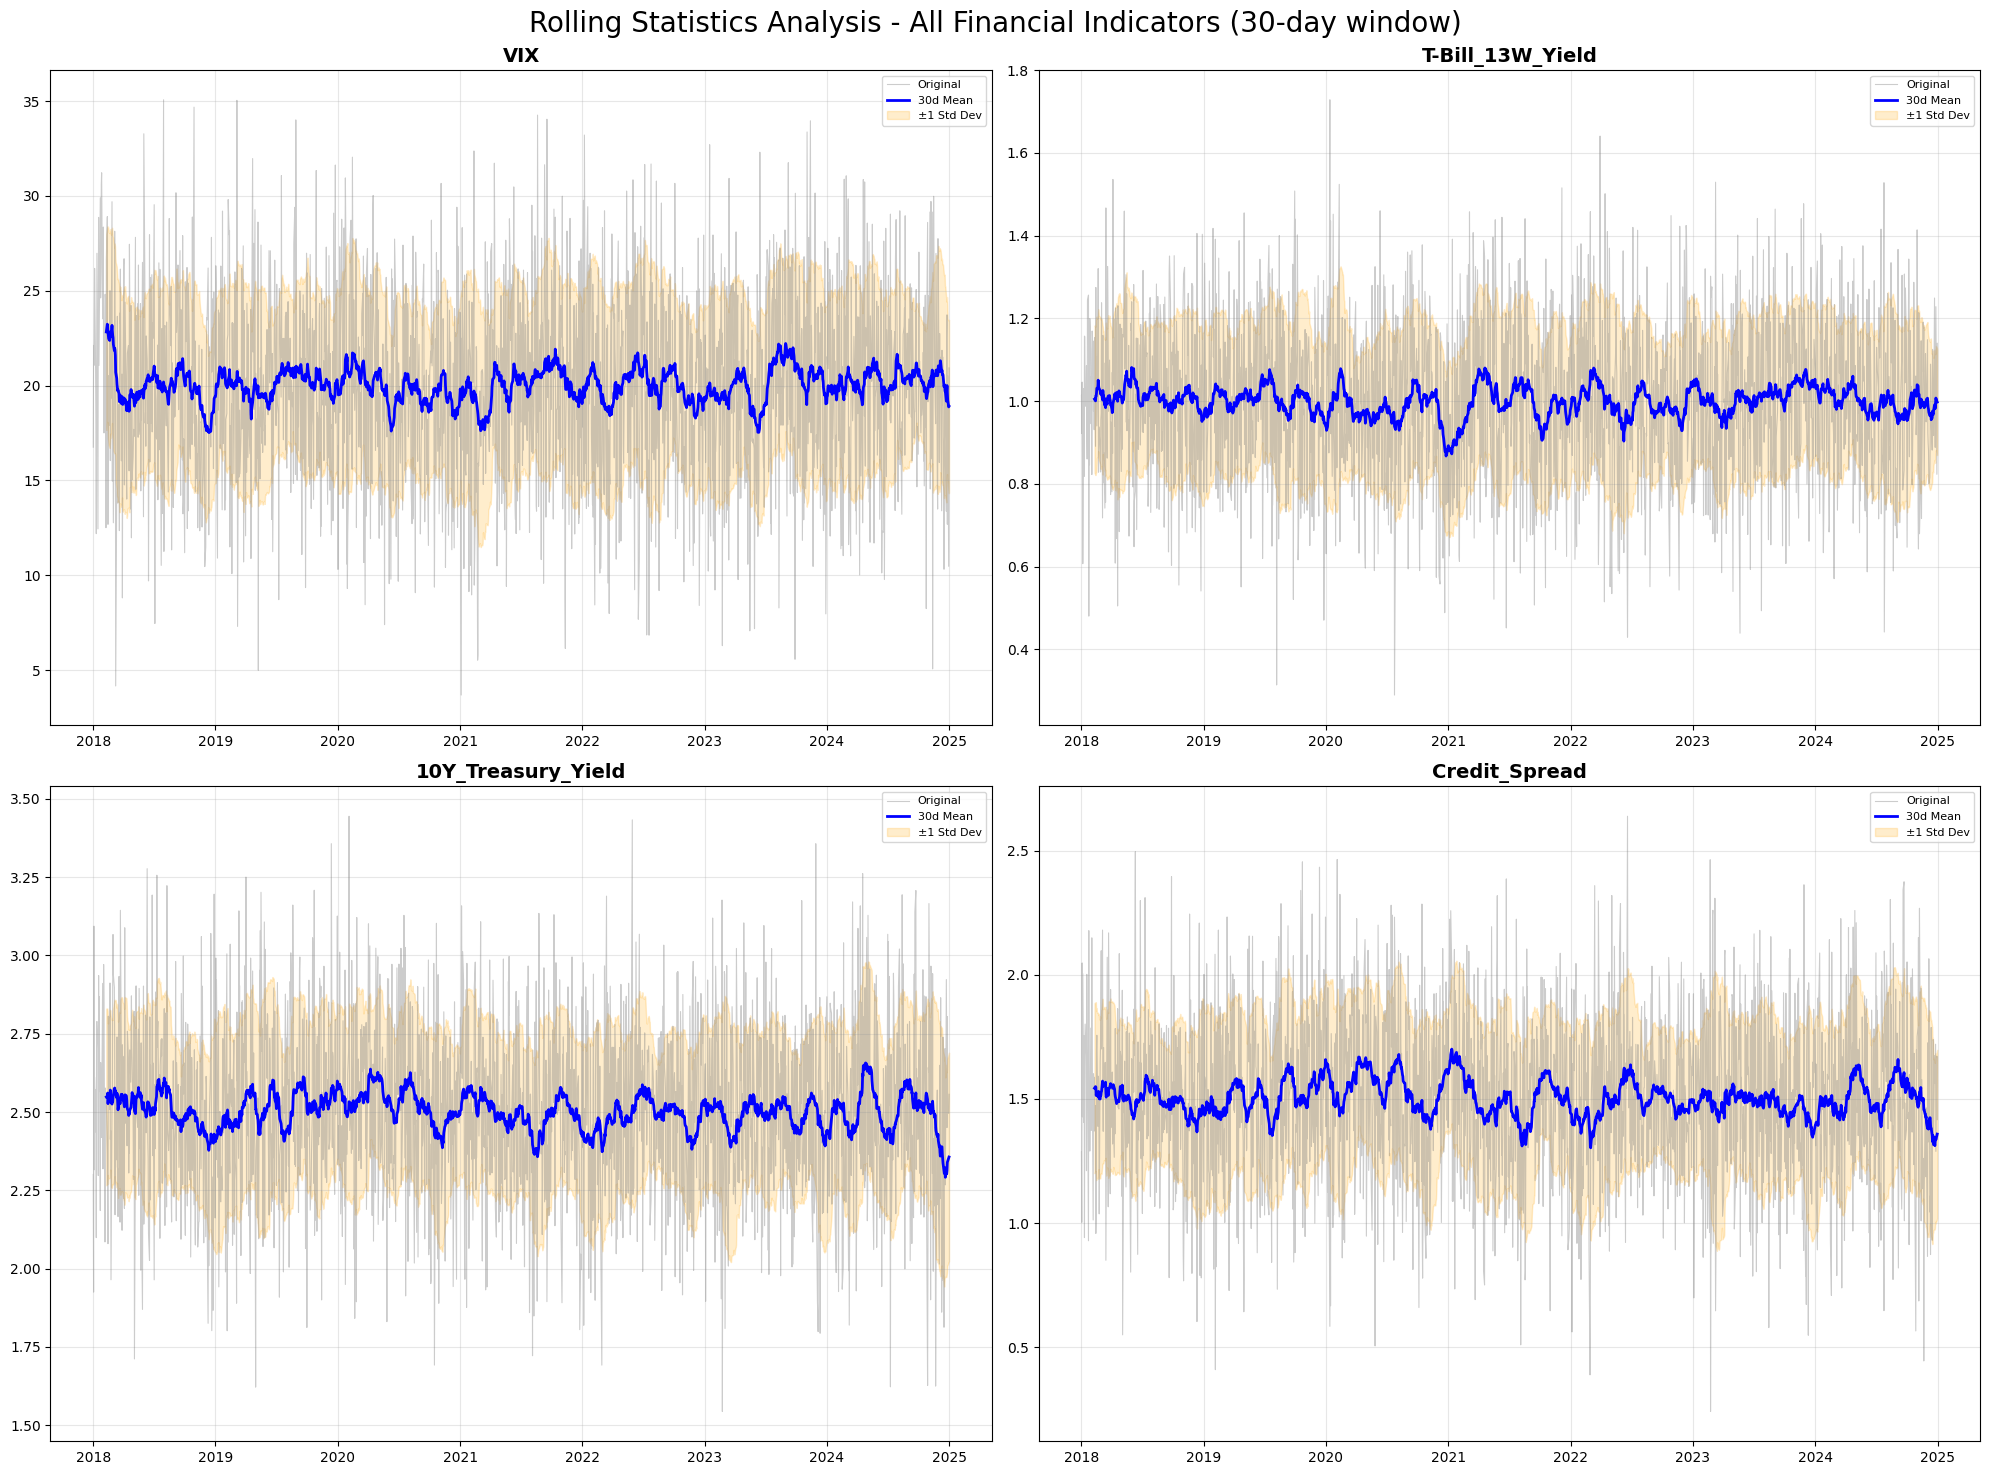

In [92]:
# 🔧 Configure rolling analysis parameters
window_size = 30  # Rolling window size (days)
save_plots = False  # Set to True to save plots

# Get available numeric columns
available_columns = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Analyzing {len(available_columns)} variables: {available_columns}")
print(f"Using {window_size}-day rolling window")

# Generate comprehensive rolling statistics for ALL variables
rolling_results = plot_all_rolling_statistics(
    df, 
    window=window_size,
    title=f"Rolling Statistics Analysis - All Financial Indicators ({window_size}-day window)",
    save_path="plots/all_rolling_statistics.png" if save_plots else None
)